### Author Predictions using NLP and machine learning techniques; understanding how language can be used to correctly identify an individual and group similar individuals together.

Online news articles are often categorized using overall categories and general context of the articles. This is great if you are interested in a specific topic. However, there may be situations where its the Author that wrote that article that is of interest to you. Maybe you like the style of writing they employ, their seemingly balanced opinions, or the controversial insights they share. In this case I believe it would be useful if there was a way to assign similarity scores between authors, and from this provide recommendations.

#### Overall the project goals are split into 3 parts;
* Gathering, cleaning, and processing Raw article data. 
* Feature engineering
* predicating who wrote an article using topic classification (found through LDA), understanding of words and sentence types using (TF-IDF) and similarities in language used. 



#### 1. Gathering, Cleaning, and Processing raw article data.
For the first part of this project we will focus on getting data prepared for future modelling and analysis, as well as this we will undertake some exploratory data analysis to get an idea of the quality of our data set and understand how applicable it is to the above goals.

##### Goals for section 1:

* web scrape a large collection of articles for use in analysis
* Ensure the format of the scraped data is in a workable format, this includes dealing with any missing data, correcting data types and ensuring the format of data is consistent.
* Check to see if there is a sufficient amount of successfully scraped data for a collection of different authors.
* each article text tokenized, with stop words and punctuation removed. We will also use a genism model to ensure we capture multi-word phrases (bigrams and trigrams)
* an overall corpus containing all tokenized text from all articles for use in TF-IDF calculations.


### Understanding what makes an author unique

To create a program that can give meaningful author reccomendations we first must understand the features define an author. Of course, this isnt a triveal task since we only have access to written text. Which as oppose to spoken language gives us little indication of tone, and no indication of external cues and prompts that we are usually aware of through body language, eye contact, and facial expressions. Despite these challanges there are several key written features that we can analysis to try and understand what makes an author unique, and from this generate a program that can objectivly search for similarites between different writers. 

#### Sentence Structure

The first key features to be aware of are those that are hidden within sentence structure. From this we can get an idea of word ordering, general context, sentiment, and an idea of how sentiment changes through an article, frequency of nouns and verbs, and the presense and frequency of sarcasm, humour, irony and much more. All of these mentioned features can give an insight into how an idividual thinks and the nuances of their own speach which can be used to identify them. 

Many of these sentence-strucutre features can be acquired through part of speech (POS) tagging (Voutilanien, 2003). This is a technique that allows us to label words with an identifier given the definition of the word, and the context in which it is used. local-context i.e context within a single sentence, or paragraph can often be infered from word-ordering but this on its own isnt enough to understand the nuances of language, for example implicit language techniques such as sarcasm. In general, POS pairs well with word embedding techniques such as word2vec, FastText, or glOve (Mikolov et al, 2013) . Word-embedding, or neural language models are a broad expansion of the basic bag-of-word architecture (Zhang, et al, 2010). Instead of looking at words individually, without any idea of context or structure, it applies algorithims that produces vector representations of words which can be used to identify similarites between words and get a broader understanding of context. 

#### Word choice

Typically, it is common practice in NLP tasks to lemmatize and/or stem words to get them in their most basic form while maintaining the original words meaning. This is ideal in most cases, but for us, the specific use of certain words or terms could be used as a feature for identifiying individuals, for example lets say we have two authors writing on the same subject, one may write the sentence:
* "John did better than Tom"


and another, 
* "John did well, when compared to Tom",  

Lemmatization of these two sentences would loose some of the personailty of the writing, "better" in sentence 1 for example, would become "well". It is possible that lemmatizaion may be needed for some of the other features we wish to use, but as a first step we will try and avoid it.

    input: lematize_test = WordNetLemmatizer()
        >> better_lem = lematize_test.lemmatize("better","r")
        >> well_lem = lematize_test.lemmatize("well","r")
        >> print(f"lemmatization of 'better': {better_lem}\nlemmatization of 'well': {well_lem}")
    
    output: lemmatization of 'better': well
          >>lemmatization of 'well': well



#### Term-weighting 

Term weighting is simply the idea of applying different weights to different words in a text based on either their frequency, or imposed importance in a given text. It is split into supervised and non-supervised term-weighting where non-supervised looks at the text as a single, large category and applies weight to words equally across the entire text. Supervised term-weighting however, seperates text into indiivdual categories, the weights applied to the word will depend on that words prevelence in its specific category. There have been a number of papers that have shown the successes of including both supervised and un-supervised term-weighting for accurate sentiment predictions. For example Carvalho and Guedes (2020) created a machine learning model for sarcasm detection, when the model was ran without any term-weighting featuers the accuracy of the model (measured by the number of tweets correctly classifed as sarcastic) was 74.59%. A second itteration of the model was ran on the same data with the top 200 TF-IDF (an example of un-supervised term-weighting) features included, the accuracy of the model increased to 81.78%. Onan and Toçoğlu (2021) also showed the importance of term-weighting by comparing a number of supervised, and un-supervised term-weighting frameworks effect on a novel neural network's success in a sentiment analysis task.


In [1]:
import sys
import csv
import time
import pandas as pd
import numpy as np
import scrapy
import random
from imblearn.over_sampling import RandomOverSampler
from scrapy.crawler import CrawlerProcess
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.common.by import By
from datetime import datetime
from datetime import timedelta
import re
from time import sleep
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from gensim.models.phrases import Phrases
import matplotlib
from gensim.utils import simple_preprocess
import string
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import validation_curve
from sklearn.inspection import permutation_importance
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import learning_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score
from hyperopt.pyll.base import scope
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import logging


import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38/bin/'

pd.options.mode.chained_assignment = None
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cthic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cthic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cthic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\cthic\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cthic\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### Gathering data
For the purpose of this project it doesnt matter too much where the data is from, we could choose from a number of news websites, blog websites, or any other kind of website that hosts article style writings. My first idea was to use "towardsdatascience". A website that hosts a large collection of data-science related articles. Unfortunately, many of the articles on here require a subscription to view and as such it would be unethical to scrape and share this data here.

With the above in mind the main considerations for choosing a data source is:
* scraping, and sharing the content scraped should be allowed and fall within the websites terms and conditions.
* There should be a large number of articles to scrape (the more the better!)
* There should be a good variety of authors, (again, the more the better!)

for this project we chose to use the BBC as our source of data. This is because the BBC allows webscraping on their website, on top of this they dont bottleneck or limit the amount of data that you can scrape. This means not only are we allowed to scrape the data, but we can do it very quickly. The BBC also clearly labels the author that wrote the article. Ontop of this, the BBC is the most viewed news source in the UK and so even though this project could be applied to a number of different websites, hopefully this one will be of particular use!



#### Webscraping the BBC

I decided to split the web scraping portion of the project into 2 parts;
1) **utilising selenium to navigate the dynamic part of the webpage.**
The BBC has some dynamic elements that change the articles that can be viewed on a given page, this can be somewhat difficult to deal with in beautifulsoup or scrapy, here we use selenium, a package often used for website testing. Selenium is capable of automatically navigating a webpage, we use this feature to traverse the dynamic elements of the page and get all the relevant article links. Selenium, relative to some other web scraping packages is quite slow. This is why we only use it for the first part of our web scraping process.

2) **utilise an asynchronous web scraper to scrape a large number of pages in short period of time**
We expect to scrape several thousand articles, for this reason we decided to make use of the Scrapy package, a popular and dedicated web scraping package that has asynchronous coding capabilities, this means when supplied upfront with a collection of links (which are created in the selenium package) it can search through and scrape them much in a parallel manner which is much faster than other packages such as BeautifulSoup.


Note: The output from the selenium scraper is rather large so i decided to clear it for the sake of filesize. If you want to see how it runs feel free to run the below code chunk. I have changed the number of pages parameter to 2 (2 pages for each supplied link). It should take about 50 seconds. I suggest clearing the output after it is finished.

In [2]:
# selenium scraper
def BBC_ArticleLink_Scraper(number_pages_to_scrape):
    """ a Web scraper that gets article links from the BBC.
    :param number_pages_to_scrape: int between 2-50. sets the number of pages to be scraped.
    :return: creates a .txt file that contains all scraped links. This can the be fed into another web scraper.
    """

    # we use webdriver-manager to install a ChromeDriver that is ready for use. 
    # This just means we dont have to deal with directing the webdriver to the file location of our drivers.
    options = webdriver.ChromeOptions()
    options.headless = True # set to False to visually see the browser-navigation
    driver = webdriver.Chrome(ChromeDriverManager().install(),options=options)
    links = ["https://www.bbc.co.uk/news/coronavirus",
             "https://www.bbc.co.uk/news/world-60525350",
             "https://www.bbc.co.uk/news/uk",
             "https://www.bbc.co.uk/news/world",
             "https://www.bbc.co.uk/news/business",
             "https://www.bbc.co.uk/news/politics",
             "https://www.bbc.co.uk/news/technology",
             "https://www.bbc.co.uk/news/science_and_environment",
             "https://www.bbc.co.uk/news/education",
             "https://www.bbc.co.uk/news/entertainment_and_arts",
             ]

    for link in links:
        print(f'Currently scraping: {link}.....')
        driver.get(link)

        number_pages_to_scrape = number_pages_to_scrape
        for i in range(number_pages_to_scrape-1):
            articles = driver.find_elements(by=By.XPATH,value="//a[contains(@class,'qa-heading-link lx-stream-post__header-link')]") # get all articles on a given page
            for article in articles:
                article_link = article.get_attribute("href") # get individual article links

                with open ('article_links_test.txt','a') as f:  # write the links to a .txt file.
                    f.write(f"{article_link}\n")

            try:
                # if a next button exists, click it to generate the next set of article links.
                next_button = driver.find_element(by=By.XPATH,value="//a[contains(@rel,'next')]")
                next_button.click()
                # loading the next page can take a few seconds, 
                # we wait for 10 seconds to ensure the page has loaded before we move on to scrape it.
                sleep(5)
            except ValueError:
                print("page not found")
                continue
    driver.quit()
# only using 2 pages for the sake of showcasing the code. this is to keep the file size to a minimum. 
# (webdrivers seem to output a lot of log data even after i added "--log-level=3" to the options)

#BBC_ArticleLink_Scraper(2)

In [3]:
# read in the article links scraped above for use in part 2 of the webscraping process.
#with open("article_links_test.txt", "r") as f:
 #content = f.read()

#article_links = content.split("\n")

In [4]:
# Scrapy web scraper.
class BBC_scraper(scrapy.Spider):
    name = "BBC scraper"

    def start_requests(self):

        for url in article_links: # all_links from selenium scraper.
            yield scrapy.Request(url=url,callback=self.article_parser)

    def article_parser(self,response):
        # below are all the elements we hope to find for each article.
        author = response.xpath("//p[contains(@class,'ssrcss-ugte5s-Contributor e5xb54n2')]/span/strong/text()").get()

        # only scrape pages that have a listed author.
        if author:

            header = response.xpath("//h1[contains(@id,'main-heading')]/text()").get()
            category = response.xpath("//span[contains(@class,'ssrcss-19k053m-LinkTextContainer eis6szr1')]/text()").get()

            article_date = response.xpath("//time[contains(@data-testid,'timestamp')]//text()").get()
            link = response.url

            text = response.xpath("//div[contains(@data-component,'text-block')]//text()").getall()

            article_item = { # using a dictionary to store data scraped from each page
                "header":header,
                "category":category,
                "author":author,
                "article_date":article_date,
                "link":link,
                "text":text,
                "date_scraped": today
            }
            all_items.append(article_item)

        else:
            pass

today = datetime.now()
all_items =[] # empty list that we will append our article data to

runner = CrawlerProcess()
runner.crawl(BBC_scraper)
# Scrapy works by initialising a twisted reactor, if one is already running the scraper fails. 
# To solve this we check if a reactor is already initialised, if it is we delete it.
# NOTE: use of twisted is what gives scrapy its asynchronous capabilities !
if "twisted.internet.reactor" in sys.modules:
    del sys.modules["twisted.internet.reactor"]
#runner.start()




2022-08-25 21:46:06 [scrapy.utils.log] INFO: Scrapy 2.6.1 started (bot: scrapybot)
2022-08-25 21:46:06 [scrapy.utils.log] INFO: Versions: lxml 4.8.0.0, libxml2 2.9.12, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 22.2.0, Python 3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)], pyOpenSSL 22.0.0 (OpenSSL 1.1.1n  15 Mar 2022), cryptography 36.0.2, Platform Windows-10-10.0.19043-SP0
2022-08-25 21:46:06 [scrapy.crawler] INFO: Overridden settings:
{}
2022-08-25 21:46:06 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2022-08-25 21:46:06 [scrapy.extensions.telnet] INFO: Telnet Password: b0e7be3bc0052a26
2022-08-25 21:46:06 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.logstats.LogStats']
2022-08-25 21:46:06 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scrapy.downloadermiddlewares.httpauth.HttpAuthMid

In [5]:
# write the scarped data to a csv.

# field_names = all_items[0].keys()

# with open ('articles_test.csv','w', encoding='utf-8',newline='') as f:
#    writer =csv.DictWriter(f,field_names)
#    writer.writeheader()
#    writer.writerows(all_items)


### Exploratory Data Analysis And processing

Here we explore the data and give an overview of it, we identify any issues that may have occurred from web scraping, and finally we process the data and get it ready for feature engineering.

In [6]:
# read in the full dataset that we previously scraped. (I.e the data scraped when the selenium scraper is set to 50 pages.)
articles_data = pd.read_csv('articles2.csv',encoding='utf-8')
articles_data.head()

,header,category,author,article_date,link,text,date_scraped
0,Sir Tom Jones: 'Honour' for Stereophonics to h...,Wales,By Peter Shuttleworth,1 day ago,https://www.bbc.co.uk/news/uk-wales-61823993,['Stereophonics star Kelly Jones has joked the...,2022-06-19 12:24:41.574271
1,Stereophonics and Sir Tom Jones Cardiff concer...,Wales,By Peter Shuttleworth,1 day ago,https://www.bbc.co.uk/news/uk-wales-61707518,['Music fans have been warned to plan ahead an...,2022-06-19 12:24:41.574271
2,Covid: Lockdown death prompts artist's show ab...,Wales,By Nicola Bryan,23 hours ago,https://www.bbc.co.uk/news/uk-wales-61825605,['An artist whose uncle died during lockdown h...,2022-06-19 12:24:41.574271
3,Covid-19 in the UK,UK,By The Visual and Data Journalism Teams,1 day ago,https://www.bbc.co.uk/news/uk-51768274,['Covid infections in the UK are up by more th...,2022-06-19 12:24:41.574271
4,Covid-19: Rise in infections in Wales accordin...,Wales,By Steve Duffy,1 day ago,https://www.bbc.co.uk/news/uk-wales-61842354,['Covid-19 infections in Wales have risen to t...,2022-06-19 12:24:41.574271


We start by looking at an overview of the data using the .describe() and .info() methods, this allows us to quickly see some common issues that could arise, for example possible duplicate records, Null counts and column data types. It also gives us a first glimpse at some potentially interesting information, for example most frequent occurrences in a given column.

In [7]:
articles_data.describe()

,header,category,author,article_date,link,text,date_scraped
count,2448,2448,2448,2448,2448,2448,2448
unique,2448,20,929,194,2448,2448,1
top,Sir Tom Jones: 'Honour' for Stereophonics to h...,Business,By Robbie Meredith,3 days ago,https://www.bbc.co.uk/news/uk-wales-61823993,['Stereophonics star Kelly Jones has joked the...,2022-06-19 12:24:41.574271
freq,1,468,74,58,1,1,2448


As we can see there are 929 unique authors and 2448 unique articles, presumably a number of these authors will have written very few articles for the BBC and as such we will not have sufficient data for modelling purposes. We will exclude any author that appears as the main author fewer than 5 times.

We also see that there are 20 unique categories. All headers and texts are unique which makes sense, Scrapy skips URLs that it has already visited so duplicates shouldn't be seen here.

Seemingly the author column has some redundent information, for example above we can see the most frequent author is "By Robbie Meredith". We of course only want the name part.

In [8]:
articles_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2448 entries, 0 to 2447
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   header        2448 non-null   object
 1   category      2448 non-null   object
 2   author        2448 non-null   object
 3   article_date  2448 non-null   object
 4   link          2448 non-null   object
 5   text          2448 non-null   object
 6   date_scraped  2448 non-null   object
dtypes: object(7)
memory usage: 134.0+ KB


#### What did we learn?

The info method showed us that there are no null values in the dataset. This shows that the web scraping was overall successful and all relevant elements were found for all pages!.

All Columns have the data type of **object**. We could have potentially fixed this for some of the variables when importing the data but when web scraping I noticed some of the columns have a variety of data types in there so I thought it best to deal with this issue separately.

#### A deeper look into the Author column

Now that we have a general overview of the data, we can start to solve some of the issues we identified. We will start with the author column.

#### Extracting the Main author from multi-author articles.

if we look at the tail end of the authors, we can also see there are many cases where there are multiple listed authors. I couldn't find any reasoning behind the order of listed authors, so I am going to assume the author listed first can be considered as the "main" author and more than likely had the most impact in the style and content of the article. We will extract the first name only in these multi-name author lists.

In [9]:
# extract the characters that exist before the first instance of "and" or "&" or ",,". 
regexes = ["^.*?(?=\ in)", "^.*?(?=\,)","^.*?(?=\ and)", "^.*?(?=\&)"]
fixed_names = []
for i in range(0,len(articles_data["author"])):
    matches = []
    for regex in regexes:
        if matches:
            pass
        else:
            try:
                main_author = re.match(regex,articles_data["author"][i]).group()
                matches.append(main_author)

            except:
                main_author = articles_data["author"][i]
    fixed_names.append(main_author)

articles_data["author_fixed"] = fixed_names

If we now take a look at the description of the author, and author_fixed columns we should notice a decrease in the number of unique authors. This is because we no longer have the complications of multi-author lists.

In [10]:
articles_data[["author","author_fixed"]].describe()

,author,author_fixed
count,2448,2448
unique,929,810
top,By Robbie Meredith,By Robbie Meredith
freq,74,74


In [11]:
# We no longer need the author column so we will drop that here. and rename author_fixed.

articles_data.drop("author",axis=1,inplace=True)
articles_data.rename(columns={"author_fixed":"author"}, inplace=True)

In [12]:
# lets take a look at the top 10 most frequent authors of the BBC over the last n days.
unique_authors = articles_data.groupby("author").agg(article_count = ("author","count")).sort_values("article_count", ascending=False)
unique_authors.head(10)



,article_count
author,
By Robbie Meredith,74
By Kevin Peachey,58
By Mark Savage,47
By Jane Wakefield,36
By Michael Race,32
By John Campbell,27
By Joe Tidy,26
By Jennifer Harby,26
By Beth Timmins,26


#### Sample size determination

Of course, the goal of this project is to create a machine learning model that can predict the author who wrote a given article, to do that we must ensure there is a sufficent amount of data for training and validation. Ideally we want to find the best balance between complexity, and number of records in the dataset. I.e we want to ensure there is enough data to create a good model, but we dont want the data to be too simple. 

We think a good starting point is using authors who have 25 or more unique articles, this leaves us with 9 authors which creates a reasonably complex multinominal-classification problem.

In [13]:
# lets filter out the authors who have less than 25 written articles.
min_articles = 25
top_authors = unique_authors.loc[unique_authors["article_count"] >=min_articles]
print(f"Number of authors with atleast {min_articles} articles on the BBC: {len(top_authors)}\n\n"
      f"{top_authors}")


Number of authors with atleast 25 articles on the BBC: 9

                    article_count
author                           
By Robbie Meredith             74
By Kevin Peachey               58
By Mark Savage                 47
By Jane Wakefield              36
By Michael Race                32
By John Campbell               27
By Joe Tidy                    26
By Jennifer Harby              26
By Beth Timmins                26


Now we have all unique BBC authors that we want to use for our analysis. We will finish this section up by cleaning the column and removing anything that doesnt belong to the persons name.

In [14]:
top_authors.reset_index(inplace=True)

def clean_names(names):
    '''removes un-wanted characters and white space.
    
    Parameters
    ----------
    
    names: an array-like of shape (n_names)
        An array that contains the names to be cleaned.
    return 
    ----------
    cleaned_names: list
        a list with the cleaned names.
    '''
    cleaned_names = [x.replace("By", "").strip() for x in names]
    return cleaned_names


top_authors["author_clean"] = clean_names(top_authors["author"])
print(top_authors)

               author  article_count     author_clean
0  By Robbie Meredith             74  Robbie Meredith
1    By Kevin Peachey             58    Kevin Peachey
2      By Mark Savage             47      Mark Savage
3   By Jane Wakefield             36   Jane Wakefield
4     By Michael Race             32     Michael Race
5    By John Campbell             27    John Campbell
6         By Joe Tidy             26         Joe Tidy
7   By Jennifer Harby             26   Jennifer Harby
8     By Beth Timmins             26     Beth Timmins


In [15]:
# Finally, we use our top_author dataframe to filter our main dataset.

top_authors.set_index("author",inplace=True)

articles_data["author"] = articles_data["author"].map(top_authors["author_clean"])
articles_to_drop = articles_data[articles_data["author"].isnull()].index

articles_data.drop(articles_to_drop,inplace=True)

In [16]:
articles_data["author"].head()

36        Mark Savage
66       Michael Race
114    Jennifer Harby
118    Jennifer Harby
119       Mark Savage
Name: author, dtype: object

In [17]:
articles_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 36 to 2444
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   header        352 non-null    object
 1   category      352 non-null    object
 2   article_date  352 non-null    object
 3   link          352 non-null    object
 4   text          352 non-null    object
 5   date_scraped  352 non-null    object
 6   author        352 non-null    object
dtypes: object(7)
memory usage: 22.0+ KB


#### Dealing with Data types and data inconsistencies.

Next we will address the datatype issue we previously introduced. This is a quick and easy task where we simply need to convert variables data types to something more relevant that could potentially make future analysis easier. On top of this, we will also deal with any inconsistencies that occur in a few of the columns, namely the text and article_date columns.

The key things to do are:

* Convert header, category, author, and link columns to strings
* Clean and process the date column so its all in a uniform format that can be converted to a date type.
* Pre-processing of the text in preparation for analysis

#### 1. Convert header, category, author, and link to strings

In [18]:
cols_to_convert_str = ["header","category","author","link"]

for col in cols_to_convert_str:
    articles_data[col] = articles_data[col].astype("string")
articles_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 36 to 2444
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   header        352 non-null    string
 1   category      352 non-null    string
 2   article_date  352 non-null    object
 3   link          352 non-null    string
 4   text          352 non-null    object
 5   date_scraped  352 non-null    object
 6   author        352 non-null    string
dtypes: object(3), string(4)
memory usage: 22.0+ KB


#### 2. Clean and process the date column so its all in a uniform format that can be converted to a date type.

In [19]:
print(f"..............first 5 articles dates......................\n"
      f"{articles_data['article_date'].head(5)} \n"
      f"..............last 5 articles dates....................... \n"
      f"{articles_data['article_date'].tail(5)}")

..............first 5 articles dates......................
36     1 June
66     23 May
114     7 May
118     6 May
119     6 May
Name: article_date, dtype: object 
..............last 5 articles dates....................... 
2417     3 April
2419     4 April
2423     1 April
2437    27 March
2444    25 March
Name: article_date, dtype: object


As shown above there are some key differences in how the "dates" data is presented. Recent articles are given as a time difference between the moment the article is viewed and when it was uploaded, and older articles are given simply as a date.

To rectify this we will simply use the date the data was scraped and apply any time differences to it to get a date format.


In [20]:
articles_data["date_scraped"].head()

36     2022-06-19 12:24:41.574271
66     2022-06-19 12:24:41.574271
114    2022-06-19 12:24:41.574271
118    2022-06-19 12:24:41.574271
119    2022-06-19 12:24:41.574271
Name: date_scraped, dtype: object

In [21]:
## convert date_scarped to datetime dtype.
articles_data["date_scraped"] =pd.to_datetime(articles_data["date_scraped"],infer_datetime_format=True)

In [22]:
def find_time_rows(word):
    '''finds the index value of rows in a dataframe where a particular word occurs.
    
    Parameters
    ----------
    word: str
        the word you are searching for
    return 
    ----------
    row_index: Pandas.Series
        the index number of the rows that contained the word.
    '''
    row_index = articles_data[articles_data["article_date"].str.find(word) >0].index
    return row_index

In [23]:
hour_rows = find_time_rows("hours")
days_rows = find_time_rows("days")
# use the index values found above to extract just the integer value from the relevant rows that contain hours 
# or days rather than a date.
hours = [int(re.search(r'\d+',x).group()) for x in articles_data.loc[hour_rows].article_date]

days = [int(re.search(r'\d+',x).group()) for x in articles_data.loc[days_rows].article_date]


In [24]:
def times_to_dates(time_type):
    '''takes times differences (hours or days) and converts them into a datetime. e.g if a row had "24 hours ago" 
    it would convert that row to a datetime that is one day prior to today().
    
    Parameters
    ----------
    time_type: str
        the format of the time difference, either "hour" or "day".

    '''
    row_index = articles_data[articles_data["article_date"].str.find(time_type) >0].index
    row_values = [int(re.search(r'\d+',x).group()) for x in articles_data.loc[row_index].article_date]
    print(f"{time_type} was found in: {len(row_index)} rows." )
    try:
        for i in range(0,len(row_index)):
            index_val = row_index[i]
            if time_type =="hour":
                articles_data.loc[index_val,"article_date"] = (articles_data.loc[index_val,"date_scraped"] - timedelta(hours=row_values[i])).date()
            if time_type=="day":
                articles_data.loc[index_val,"article_date"] = (articles_data.loc[index_val,"date_scraped"] - timedelta(days=row_values[i])).date()


    except ValueError:
        print("Unexpected time type. Choose hour or day.")
        pass


In [25]:
times_to_dates("hour")
times_to_dates("day")


hour was found in: 0 rows.
day was found in: 27 rows.


In [26]:
# dates from this year dont have a year. we will just append on 2022.

articles_data["article_date"] = [x + " 2022" if isinstance(x,str) and re.search("\d+$",x) is None else x for x in articles_data["article_date"]]



In [27]:
# finally, get all dates in the same format.

def parse_dates(dates):
    '''ensures all datetimes are converted to dates, and the format is consistent.
    
    Parameters
    ----------
   
    dates: An array-like of the shape (n_dates,)
        an array containing the dates.
    
    return
    ---------
    [datetime.strptime(x,fmt) if isinstance(x,str) else x for x in dates ]: list
        S list containing the same dates, but with a consistant date format.
    '''
    for fmt in ("%d %B", "%d %B %Y"):
        try:
            return [datetime.strptime(x,fmt) if isinstance(x,str) else x for x in dates ]
        except ValueError:
            pass
    raise ValueError("Some dates were not in an expected format")

In [28]:
articles_data["article_date"] = parse_dates(articles_data["article_date"])
articles_data["article_date"].head(15)

36    2022-06-01
66    2022-05-23
114   2022-05-07
118   2022-05-06
119   2022-05-06
161   2022-04-21
182   2022-04-13
243   2022-03-26
246   2022-03-25
256   2022-06-18
320   2022-05-31
412   2022-05-12
439   2022-05-06
460   2022-05-02
522   2022-04-20
Name: article_date, dtype: datetime64[ns]

Finally, let us once again check to makesure all fields are of the correct dtype.

In [29]:
articles_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 36 to 2444
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   header        352 non-null    string        
 1   category      352 non-null    string        
 2   article_date  352 non-null    datetime64[ns]
 3   link          352 non-null    string        
 4   text          352 non-null    object        
 5   date_scraped  352 non-null    datetime64[ns]
 6   author        352 non-null    string        
dtypes: datetime64[ns](2), object(1), string(4)
memory usage: 30.1+ KB


#### 4. Pre-processing of the text in preparation for analysis.

The final step is to prepare the text for NLP analysis.Here we will:

* tokenize the text, keeping track of what words are in which sentence. This is so we can utilise sentence structure for our future analysis. It also creates a nice foundation for full work tokenization for bag-of-words based models such as LDA.
* Remove stopwords
* Remove punctuation
* Identify bigrams such as "machine learning" and ensure these are accurately represented in the text
* We will **not** lemmatize the text at this stage. Lemmatizing text could be said to normalise the text and remove personality from it. We will instead try to model the data without this limitation, if however, models perform poorly lemmatization may end up as a much needed step.

In [30]:
def tokenize_text(text):
    '''takes a series of text bodies and tokenizes them, first into sentences, and then to words. 
    It also takes some additional steps to remove stop words and punctuation.
    Parameters
    ----------
    
    text: An array-like of the shape (n_text_documents,)
        An array that contains all the text to be tokenized.
    return
    ----------
    
    filtered_list: list
        A list of lists that contains the tokenized words of each sentence in a body of text.
    '''
    filtered_list = []
    english_stop_words = stopwords.words("english")
    english_stop_words.extend(["said","would","could","also","get","go","like","try","part","also",
                              "it's","that's","might","people","year","one","says"])

    for i in text.index:

        sent_tokens = sent_tokenize(text[i].lower())
        removed_punctuation = [i.translate(str.maketrans('','',string.punctuation)) for i in sent_tokens]

        word_tokens = [word_tokenize(i) for i in removed_punctuation]
        filtered = [[word for word in sent if word not in english_stop_words and len(word) >3] for sent in word_tokens ]
        filtered_list.append(filtered)
    return  filtered_list

In [31]:
#apply the tokenize_text function to our text data.
articles_data["text_tokens"] = tokenize_text(articles_data["text"])

now that the text is tokenized and punctuation is removed, we can apply a genism model to capture common multi-word phrases. For example, at the moment "machine learning will be captured as, ["machine", "learning"]
of course though we would want to capture this as machine-learning. This is where genism (Rehurek & Sojka, 2011) comes in.

In [32]:

def get_bigrams(articles):
    '''searches through lists of word tokens to identify potential bigrams.
    Parameters
    ----------
    articles: An array-like of the shape (n_records)
        An array containing tokenized sentences
    return 
    ----------
    finished_text: list
        A list of lists that contains tokenized sentences, and the tokenized words of those sentences. 
        with bigrams included.
    '''

    all_sentences = []

    for article in articles:
        all_sentences += article

    bigram = Phrases(all_sentences,min_count=15)

    finished_text = []
    for article in articles:
        bigram_sents = []
        for sent in bigram[article]:
            bigram_sents.append(sent)
        finished_text.append(bigram_sents)
    return finished_text


articles_data["text_tokens"] = get_bigrams(articles_data["text_tokens"])

2022-08-25 21:46:12 [gensim.models.phrases] INFO: collecting all words and their counts
2022-08-25 21:46:12 [gensim.models.phrases] INFO: PROGRESS: at sentence #0, processed 0 words and 0 word types
2022-08-25 21:46:12 [gensim.models.phrases] INFO: PROGRESS: at sentence #10000, processed 102173 words and 91015 word types
2022-08-25 21:46:12 [gensim.models.phrases] INFO: collected 97146 token types (unigram + bigrams) from a corpus of 108939 words and 10694 sentences
2022-08-25 21:46:12 [gensim.models.phrases] INFO: merged Phrases<97146 vocab, min_count=15, threshold=10.0, max_vocab_size=40000000>
2022-08-25 21:46:12 [gensim.utils] DEBUG: starting a new internal lifecycle event log for Phrases
2022-08-25 21:46:12 [gensim.utils] INFO: Phrases lifecycle event {'msg': 'built Phrases<97146 vocab, min_count=15, threshold=10.0, max_vocab_size=40000000> in 0.17s', 'datetime': '2022-08-25T21:46:12.363520', 'gensim': '4.2.0', 'python': '3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1

Next we group all article texts' together to get all words in all articles together. This will be  useful for TF-IDF calculations.

here we will also create a list containing the lengths of each individual article. This will make up one of the features used for modeling later on. 

In [33]:
# store all words from all articles
tokenized_corpus = []
# store the length of each article.
article_length = []

for sent in articles_data["text_tokens"]:
    sentence_length = []
    for text in sent: 
        sentence_length+=text
        tokenized_corpus += text
    article_length.append(len(sentence_length))

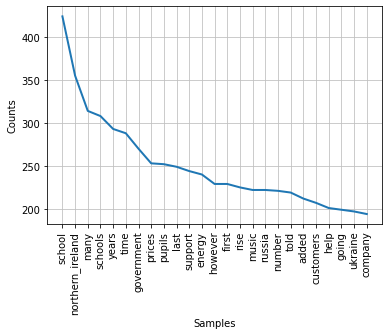

In [34]:
# remove un-necessary logs
logging.getLogger('matplotlib.font_manager').disabled = True
fd = nltk.FreqDist(tokenized_corpus)
fd.plot(25,cumulative=False)
plt.show()

#### The data is now in a good place to start feature engineering and then modelling. In part two of the project) we will:
* use the text in its current form to create a number of features that encompass sentiment, term frequencies, language used, sentence structure, length of articles, and classified topics
* use the above features to create a predictive model that can correctly identify authors
* create a separate model that can identify similarity between authors and from that, generate author recommendations.

### Feature engineering and analysis



Here we will create a number of features that will be used to better model our data. We will start with article length 
which we already defined earlier. We simply need to assign it to a column in our dataframe.

In [35]:
articles_data["text_length"] = article_length

In [36]:
articles_data["text_length"].describe()

count     352.000000
mean      302.832386
std       144.899013
min        65.000000
25%       199.750000
50%       276.000000
75%       378.500000
max      1171.000000
Name: text_length, dtype: float64

Clearly there is significant variation in article lengths, its possible that some authors prefer shorter articles, whilst others prefer longer or more detailed articles. 

In [37]:
articles_data.loc[articles_data["text_length"]==max(articles_data["text_length"])]

,header,category,article_date,link,text,date_scraped,author,text_tokens,text_length
2417,19 facts about the 2022 Grammy Awards,Entertainment & Arts,2022-04-03,https://www.bbc.co.uk/news/entertainment-arts-...,"['The Grammy Awards are upon us once again, af...",2022-06-19 12:24:41.574271,Mark Savage,"[[grammy, awards, upon, threemonth, delay, sur...",1171


#### Train test splits

Here we set up our train and test data. We will also need a validation set later but the algorithims we will be using automate the process of further splitting a training set into train/validation splits so we wont worry about it here.

Here we makesure to stratify the train test split to ensure similar class distributions are seen in both sets of data. This is important since there is a reasonably large difference between the largest, and smallest group.

We will also reset the index for both the train and test data, this isn't a needed step, but I think it makes the data more clear and easier to search through if needed.

In [38]:
X = articles_data.drop("author",axis=1)
y = articles_data["author"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123,stratify=y)

## reset index values for our train and test sets.
def reset_index(df):
    '''Simple function to reset the index of a pandas DataFrame, and drop the old index.
    
    Parameters
    ----------
    df: Pandas.DataFrame
        The DataFrame to have its index reset.
    '''
    df.reset_index(drop=True,inplace=True)

for df in [X_train, X_test, y_train, y_test]:
    reset_index(df)
    


### TF-IDF as a feature for machine learning.


In [39]:
# here we create out tf-idf feeatures. We will just use the 400 most common features for now, this is more to 
# save on recourses in later moddeling than anything else.
# vectorizers words (i.e converts them to float values which represent how common each word is in an article 
# compared to the overall corpus. We could also make use of these features later for reccomending oher articles and 
#authors by using cosine similarity scores.)


english_stop_words = stopwords.words("english")
english_stop_words.extend(["said","would","could","also","get","go","like","try","part","also",
                              "it's","that's","might","people","year","one","being","week","another","she","he"])

# initalise the vectorizer, take into account unigrams and bigrams, use the same stopwords as is used for other features and
# select the top 200 most common features.
vectorizer = TfidfVectorizer(ngram_range=(1,2),
                            stop_words=english_stop_words,
                            max_features= 400)

In [40]:
## apply the vectorizer to our text data. If we convert it to an array we should see it has the same number of rows 
# as our dataset with 200 columns (one for each of the 200 features.)

# talk about converting from sparse matrix below to a dataframe (you can use the pandas.DataFrame.sparse.from_spmatrix
# but we just do it manually as it makes it easier to name the columns)
idf_train = vectorizer.fit_transform(X_train["text"])
idf_test = vectorizer.transform(X_test["text"])

array_of_feature_train = np.transpose(idf_train.toarray())
array_of_feature_test = np.transpose(idf_test.toarray())


def create_tfidf_df(feature_array):
    '''Converts a sparse matrix of tfidf terms into a pandas DataFrame
    
    Parameters
    ----------
    
    feature_array: a sparse-matrix of the shape (n_records,n_features)
        The tf-idf values
    
    return
    ---------
    
    pd.DataFrame(tfidf_dict): pandas.DataFrame
        the tfidf features, in the form of a pandas DataFrame
    '''
    tfidf_dict = {}
    for i in range(0,len(feature_array)):
        tfidf_dict[f"tfidf{i}"] = feature_array[i]
    return pd.DataFrame(tfidf_dict)


tfidf_train =create_tfidf_df(array_of_feature_train)
tfidf_test = create_tfidf_df(array_of_feature_test)

X_train = pd.concat([X_train,tfidf_train],axis=1)
X_test = pd.concat([X_test,tfidf_test],axis=1)

### LDA features for header text data.

Here we use the Latent Dirichlet Allocation(LDA) algorithim to split article headers into different grouped topics. The current column category is made up of very broad topics, the hope with LDA is to narrow down on more specific topic areas, for example; COVID, Ukraine/Russia war, English Goverment, Irish Goverment etc.

First we must ensure the headers are all in a similar format, namely they are all lower cased, free of punctuation, and have no stop words. Luckily we can make use of the previously defined tokenize_text function for this.

In [41]:
## pre-proccessing of the header-field

# tokenize, remove punctuation, and remove stop words.
X_train["header_tokens"] = tokenize_text(X_train["header"])
X_test["header_tokens"] = tokenize_text(X_test["header"])
# create bigrams if they exist
X_train["header_tokens"] = get_bigrams(X_train["header_tokens"])
X_test["header_tokens"] = get_bigrams(X_test["header_tokens"])



2022-08-25 21:46:13 [gensim.models.phrases] INFO: collecting all words and their counts
2022-08-25 21:46:13 [gensim.models.phrases] INFO: PROGRESS: at sentence #0, processed 0 words and 0 word types
2022-08-25 21:46:13 [gensim.models.phrases] INFO: collected 2144 token types (unigram + bigrams) from a corpus of 1448 words and 235 sentences
2022-08-25 21:46:13 [gensim.models.phrases] INFO: merged Phrases<2144 vocab, min_count=15, threshold=10.0, max_vocab_size=40000000>
2022-08-25 21:46:13 [gensim.utils] DEBUG: starting a new internal lifecycle event log for Phrases
2022-08-25 21:46:13 [gensim.utils] INFO: Phrases lifecycle event {'msg': 'built Phrases<2144 vocab, min_count=15, threshold=10.0, max_vocab_size=40000000> in 0.02s', 'datetime': '2022-08-25T21:46:13.767617', 'gensim': '4.2.0', 'python': '3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19043-SP0', 'event': 'created'}
2022-08-25 21:46:13 [gensim.models.phrases] INFO

### Lemmitization of header text.

Earlier we disscused the benefits and shortcomings of lemmitizing text, and decided lemmitization of the article body text should be avoided unless absolutly needed. For the purpose of LDA and topic classification however, lemmitization will help create more well-defined groups.

In [42]:
## lemmitizing the header tokens.
lemmatizer = WordNetLemmatizer()

def header_lemmatizer(text,tagging = True):
    ''' Takes Either a list of pandas series of text, and lemmatizers each sentence within each body of text. 
    Parameters
    ----------
    text: array-like of shape(n_text_documents)
        The text to be lemmaztized 
    tagging: Boolean
        If True POS tagging is used for lemmatization
        (default: True)

    
    return
    ---------
    text_output: list
        A list of lists that contain the lemmatized words from text.  
    '''
    # if text is of the wrong type, return a Type error.
    if not isinstance(text,(list,pd.Series)):
        raise TypeError("text must be either a list, or pandas series")
    
    
    text_output=[]
    for sentences in text:
        sentence_output=[]
        for sentence in sentences:
            if tagging:
                tagged_sentence = pos_tag(sentence)
                tags_cleaned = [(word,tag[0].lower()) if tag[0] in ("V","A","R","S") else (word,"n") for word,tag in tagged_sentence  ]
                # add pos tag in the lemmatize method below
                lemmatized_sentence = [lemmatizer.lemmatize(w,t) for w,t in tags_cleaned]
            else:
                lemmatized_sentence = [lemmatizer.lemmatize(w) for w in sentence]
                
            sentence_output+=lemmatized_sentence
        text_output.append(sentence_output)
    return text_output
X_train["header_tokens"] = header_lemmatizer(X_train["header_tokens"])
X_test["header_tokens"] = header_lemmatizer(X_test["header_tokens"])

### Generating WordClouds from the cleaned text

WordClouds allows us to visually see the most freqnet words in the data. This can give an indication as to how many topic groups we should be using for LDA, or even if creating meaningful topic groups is possible.

Below we generate two WordClouds. The first using the header text, the second using the article body text. We can intuitvily see that using header data is much better for our LDA feature, the most common words are much more impactful and relate more to actual topics. The Wordcloud from the article text contains a signficant amount of "filler" text that would create confusion in LDA topic classification. 

Interestingly a few of our bi-grams have made it into the word cloud. For example "ukraine_war", "boris_johnson","northern_ireland", and "climate_change".

In [43]:
# First we create a single string that contains all header words.
header_corpus = []

for sent in X_train["header_tokens"]:
        header_corpus += sent
  

In [44]:
# function to create a wordcloud object when given a string.

def generate_wordcloud(text):
    '''Takes a Pandas.Series that contains tokenized text and creates a word-cloud.
    
    Parameters
    ----------
    
    text: pandas.Series
        The Series that contain the tokenized text to be used for the wordcloud.
        
        
    return
    ----------
    wordcloud.generate(joined_text): generated object
        A generator that can be used to create the plot.
    
    '''
    joined_text = " ".join(text)
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    return wordcloud.generate(joined_text)



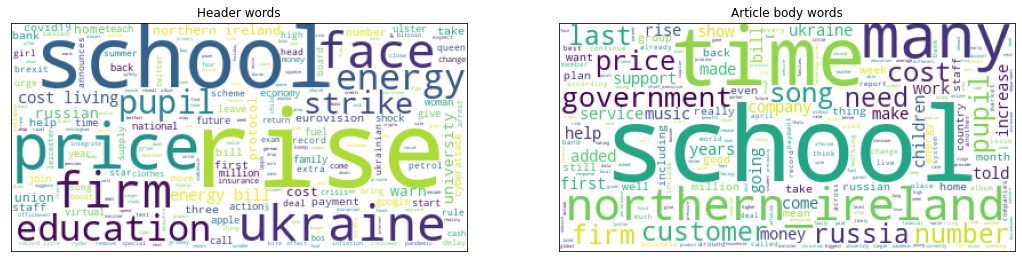

In [45]:

#wordcloud from headers
header_wordcloud = generate_wordcloud(header_corpus)
#wordcloud for article bodies
article_body_wordcloud = generate_wordcloud(tokenized_corpus)


f, (ax1, ax2) = plt.subplots(1, 2,figsize=(18, 18))
ax1.imshow(header_wordcloud)
ax1.set_title("Header words")
ax2.imshow(article_body_wordcloud)
ax2.set_title("Article body words")
plt.setp([ax1,ax2], xticks=[], yticks=[])

plt.show()

### Wordcloud results

Clearly there are a number of distinct topics to be discovered in this group of headers. Especially surrounding school, covid, the ukraine/russia war, and energy/price of living costs.

From here we will take a "trial-and-error" approach to LDA topic classifcaiton by altering paremeters until we have a reasonable number of topics that describe articles well.

### LDA model creation and analysis

Similar to when we generated our tf-idf features, we first must vectorize the text. Here we have already removed stopwords and generated ngrams, so the only argument we need to define is the max_features.

In [46]:
X_train["header_LDA"] = [" ".join(header) for header in X_train["header_tokens"] ]
X_test["header_LDA"] = [" ".join(header) for header in X_test["header_tokens"] ]

In [47]:
X_test.shape

(117, 410)

In [48]:
def LDA_optimization(data):
    '''For a given corpus, we identify the ideal number of features and topics to be used for LDA classification. The
    metric used to determine the best parameters is; The average maximum value seen for each itteration.
    The outcome of each test-itteration is printed in the form (n_features,n_topics), avg_maximum_value
    
    Parameters
    ----------
    
    data: pandas.Series
        The data to be used for generating LDA_features, and the data to be transformed.
        
    return
    ---------
    
    LDA_dict: dict
        The results of all itterations of the test.
    
    
        
    '''
    # take a random sample from our dataset for use in optimization.
    LDA_dict = {}
    # itterate through a number of max_feature values (i)
    for i in range(400,600,10):
        vectorizer_headers = TfidfVectorizer(max_features=i)
        LDA_features = vectorizer_headers.fit_transform((data.values))
        # itterate through a number of number of topic values (j)
        for j in range(4,12):
            lda_model=LatentDirichletAllocation(n_components=j,
            learning_method='batch',random_state=42,max_iter=10) 
            lda_top = lda_model.fit_transform(LDA_features)
            # for each header, find the maximum LDA value (i.e the highest % chance it belongs to a particular group)
            # and then average it to get an idea of how good a particular set of parameters were.
            LDA_dict[(i,j)] = np.mean([max(x) for x in lda_top])
            print(f"{i,j} average maximum value: {LDA_dict[(i,j)]} ")
    return LDA_dict
            

In [49]:
LDA_values = LDA_optimization(X_train["header_LDA"])

(400, 4) average maximum value: 0.7138075338450788 
(400, 5) average maximum value: 0.7113620750955828 
(400, 6) average maximum value: 0.699377013899855 
(400, 7) average maximum value: 0.6969119307889519 
(400, 8) average maximum value: 0.6906835362648963 
(400, 9) average maximum value: 0.6843081650492255 
(400, 10) average maximum value: 0.6801718003507212 
(400, 11) average maximum value: 0.680932492015837 
(410, 4) average maximum value: 0.7150648668599187 
(410, 5) average maximum value: 0.7085120658095335 
(410, 6) average maximum value: 0.7065342343511262 
(410, 7) average maximum value: 0.6984938975412252 
(410, 8) average maximum value: 0.6926588383042059 
(410, 9) average maximum value: 0.6859641196442888 
(410, 10) average maximum value: 0.6867244032902496 
(410, 11) average maximum value: 0.6738276603216546 
(420, 4) average maximum value: 0.7223184782179978 
(420, 5) average maximum value: 0.7139929691444526 
(420, 6) average maximum value: 0.7032858392547998 
(420, 7) a

(590, 10) average maximum value: 0.7055298511416546 
(590, 11) average maximum value: 0.7015072748371275 


In [50]:
# check to see the best number of features and categories seen in our test.
max(LDA_values, key=LDA_values.get)

(570, 4)

Our test suggests that for a corpus of our size, we should be aiming to use all feautres and relatively few categories.

In [51]:
vectorizer_headers = TfidfVectorizer(max_features=520)

LDA_features_train = vectorizer_headers.fit_transform((X_train["header_LDA"].values))

In [52]:
lda_model=LatentDirichletAllocation(n_components=10,
learning_method='batch',random_state=42,max_iter=10) 
lda_top_train=lda_model.fit_transform(LDA_features_train)

In [53]:
print("Document 0: ")
for i,topic in enumerate(lda_top_train[0]):
  print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  3.7030000306315176 %
Topic  1 :  3.7027360100307027 %
Topic  2 :  3.702736027874417 %
Topic  3 :  3.703074256092189 %
Topic  4 :  3.704593318225322 %
Topic  5 :  3.70326428998221 %
Topic  6 :  3.7031078543025924 %
Topic  7 :  3.7028266532125613 %
Topic  8 :  3.7027564964268094 %
Topic  9 :  66.67190506322169 %


In [54]:
vocab = vectorizer_headers.get_feature_names_out()
for i, comp in enumerate(lda_model.components_):
     vocab_comp = zip(vocab, comp)
     sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
     print("Topic "+str(i)+": ")
     for t in sorted_words:
            print(t[0])
            

Topic 0: 
boost
education
firm
school
scheme
bring
doubt
derbyshire
since
queen
Topic 1: 
team
messenger
family
ukraine
face
clothes
keep
boss
russian
arrest
Topic 2: 
troll
twitter
test
verge
mouth
vacuum
russiaukraine
internet
police
come
Topic 3: 
price
home
energy
bill
rise
branch
rival
supermarket
church
office
Topic 4: 
ireland
northern
rise
price
million
energy
protocol
shock
warn
reveal
Topic 5: 
payment
apple
sigrid
world
prize
credit
rocky
shoot
urge
brexit
Topic 6: 
school
board
2022
product
woman
bank
money
eurovision
approach
three
Topic 7: 
bitcoin
cost
living
diesel
litre
rise
help
record
call
payroll
Topic 8: 
ukraine
2022
pupil
supply
action
special
eurovision
first
school
russian
Topic 9: 
energy
face
delay
rise
bill
backlash
apps
school
decade
month


In [55]:
## now that we have created our LDA model, we can apply it to the unseen test data.
# we had an issue here where the number of featers we wanted to use (and choose to use in the train set was too big 
#for the test set. i.e we wanted to use 570 features but the test set legit only had 420... talk about this issue.)
#use our vectorizer object to create LDA features.
LDA_features_test = vectorizer_headers.fit_transform((X_test["header_LDA"].values))

## use our trained LDA model on the test data.

LDA_top_test = lda_model.transform(LDA_features_test)


In [56]:
LDA_top_test.shape

(117, 10)

In [57]:
## now we add our LDA features back onto the main datasets.

def concat_LDA_features(LDA_array):
    '''Takes a sparse matrix that contain LDA features and creates a pandas dataframe for easy merging.
    
    Parameters
    ----------
    LDA_array: array-like of shape (n_records,n_features)
        The raw transformed output from NLTK's lda_model
    
    return
    ------
    pd.DataFrame(LDA_dict): Pandas.DataFrame
        a dense, dataframe that contains the LDA_features defined by LDA_array.
    
    '''
    LDA_dict = {}
    # Currently the array's dimensions are wrong. transposing will fix this and allow us to generate a dictonar
    LDA_array_transposed= np.transpose(LDA_array)
    for i in range (0,len(LDA_array_transposed)):
        LDA_dict[f"LDA_feature{i}"] = LDA_array_transposed[i]
    return pd.DataFrame(LDA_dict)

In [58]:
# create a dataframe with our LDA features
X_train_LDA_features = concat_LDA_features(lda_top_train)
X_test_LDA_features = concat_LDA_features(LDA_top_test)

# add our LDA features to the main dataset
X_train = pd.concat([X_train,X_train_LDA_features],axis=1)
X_test = pd.concat([X_test,X_test_LDA_features],axis=1)

Train initial model to see where we are at.

In [59]:
## remove fields we dont want2cat
fields_to_drop = ["header","article_date","link","text","date_scraped","text_tokens","header_tokens","header_LDA"]

for df in [X_train,X_test]:
    df.drop(fields_to_drop,axis=1,inplace=True)

For the purposes of one hot encoding we will first group together the train and test data and then apply the algorithim. This ensures the same cateogires are present in both datasets. For example, If there is a rate occurance of a particular category it may only appear in one of the datasets which would cause issues since the train and test data would have a different number of features.

Before appending the datasets together we will create a label-columns so we can keep track of which row of data belongs to which dataset.

In [60]:
X_train["DataLabel"] = 0
X_test["DataLabel"] = 1

recombined_data = pd.concat([X_train,X_test])
recombined_data.reset_index(inplace=True,drop=True)

In [61]:
recombined_data

,category,text_length,tfidf0,tfidf1,tfidf2,tfidf3,tfidf4,tfidf5,tfidf6,tfidf7,...,LDA_feature1,LDA_feature2,LDA_feature3,LDA_feature4,LDA_feature5,LDA_feature6,LDA_feature7,LDA_feature8,LDA_feature9,DataLabel
0,Business,279,0.029993,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.037027,0.037027,0.037031,0.037046,0.037033,0.037031,0.037028,0.037028,0.666719,0
1,N. Ireland,110,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.031064,0.031063,0.031063,0.031065,0.031064,0.031063,0.031063,0.031064,0.720421,0
2,N. Ireland,188,0.000000,0.040152,0.000000,0.0,0.0,0.000000,0.052041,0.045144,...,0.027468,0.027464,0.027463,0.027462,0.027463,0.027466,0.027462,0.027471,0.027463,0
3,N. Ireland,344,0.031155,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.040591,...,0.031128,0.031128,0.031133,0.031128,0.031133,0.031132,0.031129,0.031130,0.031129,0
4,Business,422,0.000000,0.023397,0.000000,0.0,0.0,0.028011,0.000000,0.026307,...,0.030938,0.030938,0.030943,0.721548,0.030938,0.030938,0.030938,0.030940,0.030940,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,England,117,0.000000,0.138293,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.150138,0.027437,0.132121,0.027437,0.027437,0.027441,0.027437,0.180974,0.027437,1
348,N. Ireland,402,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.026127,0.119386,0.119147,0.178375,0.026127,0.298736,0.026127,0.026127,0.026128,1
349,Entertainment & Arts,297,0.000000,0.000000,0.052541,0.0,0.0,0.000000,0.053037,0.046008,...,0.029026,0.029022,0.029045,0.029026,0.029028,0.029022,0.029023,0.029022,0.483129,1
350,Technology,98,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.029011,0.028990,0.265739,0.147297,0.265794,0.028997,0.028990,0.029004,0.147189,1


In [62]:
def OneHotEncoding(df,col_names,DropCol=False):
    '''A simple function to apply sklearn's OneHotEncoder to any number of columns in a given dataframe.
    
    Parameters
    ----------
    
    df: pandas.DataFrame
        The dataframe that contain the columns to be encoded.
    
    col_names: array-like of shape (n_columns)
        The columns within df that you wish to encode.
    
    DropCol: Boolean
        If True, it drops the columns in col_names after applying OneHotEncoding.
        (default: False).
    
    return
    ------
    
    pd.concat([df,encoded_category],axis=1): pandas.DataFrame
        A version of df that has the encoded categories. If DropCol is True it will not have the original columns
        supplied in col_names.
    '''
    
    # one hot encode the category variable
    encoder = OneHotEncoder()
    
    # convert our categories variable to an array of shape (nsamples,nfeatures) which is the required format.
    #categories = df["category"].array.reshape(-1,1)
    
    # apply onehot encoding, and convert it to a dataframe.
    for col in col_names:
        encoded_category = pd.DataFrame(encoder.fit_transform(df[[col]]).toarray())
    
    # rename columns, and concatenate back onto the modelling dataset.
        encoded_category.columns = [f"cat{i}" for i in (encoded_category)]
        if DropCol:
             df = df.drop([col],axis=1)
    return pd.concat([df,encoded_category],axis=1)




In [63]:
recombined_data = OneHotEncoding(recombined_data,["category"],True)
# now we can split the data back into train and test.
X_train = recombined_data.loc[recombined_data["DataLabel"] ==0]
X_test = recombined_data.loc[recombined_data["DataLabel"] ==1]

In [64]:
# before we can being modelling we need to ensure all of our fields are of a numerical dtype i.e integers or floats.

X_train["tfidf0"].dtype == 'float64'


def CheckNumerical(df):
    '''A basic function that checks how many columns in a dataframe are of type int64, or float64. It outputs the number
    of float, int, and the proportion of total columns that are numerical.
    
    Parameters
    ----------
    
    df: pandas.DataFrame
        The Dataframe to be checked.
    '''
    float_count = 0
    int_count = 0

    for col in df.columns:
        if df[col].dtype =='float64':
            float_count +=1
        if df[col].dtype =='int64':
            int_count +=1
            
    print(f"There are: \n \
            {float_count} fields with dtype float64 \n\n \
            there are {int_count} fields with dtype int64 \n\n \
            {(float_count + int_count)} / {len(df.columns)} are numerical.")

In [65]:
CheckNumerical(X_train)

There are: 
             416 fields with dtype float64 

             there are 2 fields with dtype int64 

             418 / 418 are numerical.


In [66]:
CheckNumerical(X_test)

There are: 
             416 fields with dtype float64 

             there are 2 fields with dtype int64 

             418 / 418 are numerical.


In [67]:
# Naive Bayes Classifier for Multinomial data

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [68]:
print(classification_report(y_test, y_pred,zero_division=1))

                 precision    recall  f1-score   support

   Beth Timmins       1.00      0.00      0.00         9
 Jane Wakefield       0.75      0.25      0.38        12
 Jennifer Harby       1.00      0.00      0.00         9
       Joe Tidy       1.00      0.00      0.00         9
  John Campbell       1.00      0.00      0.00         9
  Kevin Peachey       0.53      1.00      0.69        19
    Mark Savage       0.34      1.00      0.51        15
   Michael Race       1.00      0.00      0.00        11
Robbie Meredith       0.73      1.00      0.84        24

       accuracy                           0.52       117
      macro avg       0.82      0.36      0.27       117
   weighted avg       0.76      0.52      0.39       117



### Initial test-model results

As we can see, our inital test-model's performance is fairly poor. The overall model has an f1-score of just over 0.50, with many of the individual authors having an f1-score of 0. This suggests there could be a few issues with the model and data. The first major issue is one of data volume. Not only do we not have much total data, but the data which we do has is somewhat in-balanced (which can be seen in the above output, look at the differences in support). This is currently resulting in lots of our predictions falsy classifying an author as one of the more popular ones. There are a few potential solutions to this, first, we could try and **over-sample** the minority groups with the assumption that more even group distribtuions will help solve the issues surrounding precision. We could also ensure we are using stratified splitting and validation, This will ensure the distribituion of classes in the trian and test set is equal, which again will help with the above mentioned problem. 

### Understanding feature importance

Before we move on to employing some of these techniques, we will take a quick look at feature importance. To check this we will create a simple randomforest classifier, which has the very useful feature of being able to visual how important any single feature is for the given model. Since we are just wanting a general overview we will not waste time with cross validating or optimising the model. 




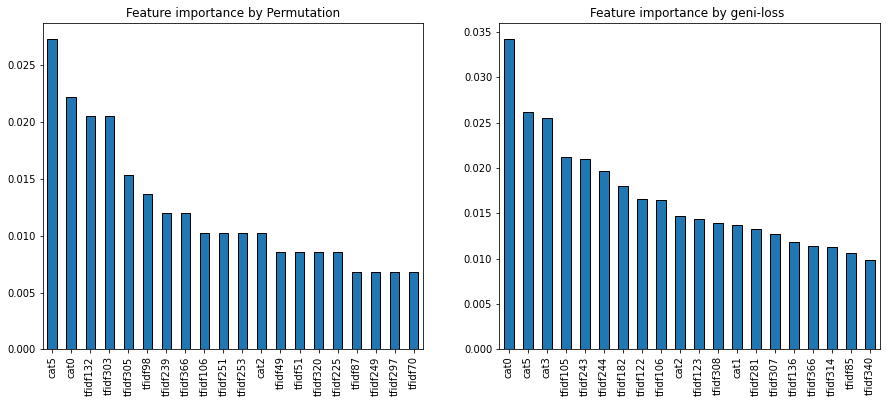

In [69]:
# understanding feature importance

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)


feature_names = list(X_train.columns)


perm_results = permutation_importance(
    rf_clf, X_test, y_test, n_repeats=5, random_state=123, n_jobs=4
)

perm_means = perm_results.importances_mean

feature_importance = pd.Series(perm_means, index=feature_names)

feature_importance_top20 = feature_importance.nlargest(20)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.set_title("Feature importance by Permutation")
ax2.set_title("Feature importance by geni-loss ")



feature_importance_top20.plot.bar(ax=ax1,edgecolor='black')

# geni importance 

geni_results = rf_clf.feature_importances_

feature_importance_geni = pd.Series(geni_results, index=feature_names)

feature_importance_geni_top_20 = feature_importance_geni.nlargest(20)
feature_importance_geni_top_20.plot.bar(ax=ax2,edgecolor='black')




plt.show()

From the simple random forest model above it is clear to see that the "cat" variables are fairly important features. This is probably due to the fact that we are only classifying a handful of authors and by chance, they are split somewhat fairly well between different categories.  

Due to the limited number of authors, and the power of the category feature, we will remove it and build a model that doesnt require this information. The primary goal of this project is to develop a **generalizable** model that can predit which author wrote a piece of text, based on the text its self. Not some pre-established classification.

The thing to note is that feature importance very rapidly drops off. This suggests there are a number of features that dont offer much to the overall model. Implementing PCA for dimension-reduction could be a good next.

In [70]:
X_train_new = X_train.drop(["cat0","cat1","cat2","cat3","cat4","cat5"],axis=1)
X_test_new = X_test.drop(["cat0","cat1","cat2","cat3","cat4","cat5"],axis=1)

In [71]:
# lets train our Naievebayes model again on the new data that doesnt have the category features.
clf2 = MultinomialNB()
clf2.fit(X_train_new,y_train)

ypred_clf2 = clf2.predict(X_test_new)

clf2_report = classification_report(y_test,ypred_clf2,zero_division=1)

print(clf2_report)


                 precision    recall  f1-score   support

   Beth Timmins       1.00      0.00      0.00         9
 Jane Wakefield       1.00      0.08      0.15        12
 Jennifer Harby       1.00      0.00      0.00         9
       Joe Tidy       1.00      0.00      0.00         9
  John Campbell       1.00      0.00      0.00         9
  Kevin Peachey       0.64      0.74      0.68        19
    Mark Savage       0.23      1.00      0.38        15
   Michael Race       1.00      0.00      0.00        11
Robbie Meredith       0.83      1.00      0.91        24

       accuracy                           0.46       117
      macro avg       0.85      0.31      0.24       117
   weighted avg       0.81      0.46      0.36       117



We see an overall drop in accuracy by ~12% when removing the category features, but we believe it makes a more robust model that could be better applied to text outside of the BBC website.


In [72]:
test_test = GradientBoostingClassifier(max_features=20,n_estimators=100)
test_test.fit(X_train_new,y_train)
test_results = test_test.predict(X_test_new)

print(classification_report(y_test,test_results))

                 precision    recall  f1-score   support

   Beth Timmins       0.40      0.22      0.29         9
 Jane Wakefield       0.90      0.75      0.82        12
 Jennifer Harby       1.00      1.00      1.00         9
       Joe Tidy       0.88      0.78      0.82         9
  John Campbell       1.00      0.89      0.94         9
  Kevin Peachey       0.68      1.00      0.81        19
    Mark Savage       1.00      1.00      1.00        15
   Michael Race       0.67      0.55      0.60        11
Robbie Meredith       0.96      1.00      0.98        24

       accuracy                           0.85       117
      macro avg       0.83      0.80      0.81       117
   weighted avg       0.84      0.85      0.84       117



### Dealing with imbalances in the data

One major consideration that up to now has gone un-explored is the fact that the data is imbalanced. 

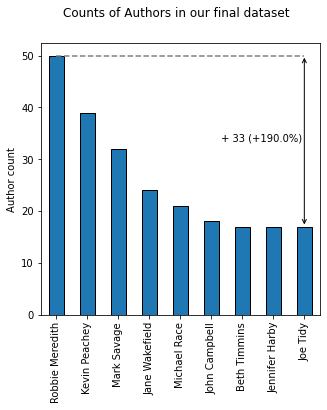

In [73]:
# creat a plot to show the imbalance in the data

# variables used for plotting 
author_counts = y_train.value_counts()
max_author_count = author_counts.max()
min_author_count = author_counts.min()
author_count_range = max_author_count - min_author_count
auth_counts_pct_dif = round((max_author_count - min_author_count )/min_author_count,1)*100
author_mid_point = (max_author_count + min_author_count)/2
number_authors = len(author_counts)-1


fig, ax1 = plt.subplots(1,1,figsize=(5,5))
fig.suptitle("Counts of Authors in our final dataset")

author_counts.plot.bar(ax=ax1,width=0.5,edgecolor='black',capsize=5)

ax1.set_ylabel("Author count")
# arrows to show difference between min and max
ax1.annotate(text='', xy=(number_authors,min_author_count), xytext=(number_authors,max_author_count), arrowprops=dict(arrowstyle='<->'),c="grey")
ax1.hlines(max_author_count,0,number_authors,linestyles="--",colors="grey")
ax1.annotate(text=f"+ {author_count_range} (+{auth_counts_pct_dif}%)", xy=(number_authors,max_author_count), xytext=(number_authors-2.7,author_mid_point),c="black")
plt.show()

### XGboost vs GBM 


Above we determined that gradient boost models are out-performing the Naieve Bayes model we produced, next we will create, optimise and validate two of the most powerful gradient boost models, namely XGboost and sklearn's implementation of a GBM.



### hyperopt

For parameter optimization we will be making use of the hyperopt package which provides an easy-to-use framework for hyperoptimization, it can be used on any model, including those found in sklearn's package and also XGboost. 

The order of operation for hyperopt optimzation is as follows:

* You first must define a **parameter space** which is a dictonary that holds the paramter information, hyperopt provides some utilities for easy parameter expression, for example the *uniform* and *quniform* functions from *hyperopt.hp* can be used to generate uniformally distributed values that are either float values, or integers between two limits, which can be used for itterating through different values of a parameter that takes a numeric argument, *choice* can be used for a similar purpose but for string arguments. 



* Once a parameter space has been defined an **objective** function must be created, this is where the model its self is built, the only difference is; instead of defining parameters as absolute values, you make a call the paramater space dictonary and use the keys defined there. Any other calculations, or statistical tests that are wanting to be performed on each itteration of the model should also be included in the objective function. As an example, we will be performing k-fold cross validation on both of our models, and extracting cross_validation scores in the objective function. The objective function should return a dictonary that contains A) The loss function being used to determine the best set of parameters (In our case, its the mean cross validation score) and optionally the status, (hyperopt.STATUS_OK) which just provides a label that ensures only itterations there were succesful are used in the final results.

* Finally, hyperopt.fmin can be called. This hyperopt function brings together the parameter space dictonary, the user-defined objective, and several other parametrs such as number of itterations, algorithim to be used for searching through the paramter space, and if trials should be used.

NOTE: The use of trials allows the user to look at the results and inputs of individual itterations formulated by fmin.


It is also worth mentioning that we will limit the maximum evaluations to 50 due to limitations in available CPU. If we were working with more simple models, or had access to more CPU we would almost certainly benefit from increasing this number.


### Creating a fair comparison

Both algorithims beings tested are tree-based and gradiant boosted. For this reason, many of the parameters being tested are the same. Where possible, these parameters are tested within the same range on each model. We are also using the same loss function for both (log loss) and weighted f1_scores to show validation performance. Both models will stop if 10 consecutive loss values are the same, this will help prevent over-fitting, and speed up run-time.

Trial times will also be tested for both algorithims so we can get an understanding of both predictive performance, and resource cost.

In general, tree based ensemble methods are fairly robust, as such, in general the more estimaters we can use the better. However, for the sake of run time we will limit the number of estimaters to 500. It is very likely that increasing it past this number will offer some small benefit to accuracy.

In [74]:
## XGboost requires labels to be encoded.
authors_encoded = {author:str(numb) for numb,author in enumerate(y_train.unique())}
authors_encoded

y_train_encoded = y_train.replace(authors_encoded).astype(int)
y_test_encoded = y_test.replace(authors_encoded).astype(int)

In [75]:
#hyperopt.tpe produces some fairly irelevent log outputs, for this reason we will just remove them
loggers_to_remove = [
    "hyperopt.tpe"
]
for logger in loggers_to_remove:
    logging.getLogger(logger).setLevel(logging.ERROR)

### GBM parameters

One of the benefits of GBMs is that they come with a huge variety of paramers which means there is alot of room for optimization. Here we give an brief explanation of all parameters used in our validation and optimisation process.

* **Learning rate**: This parameter limits the significance of each individual tree, generally, a lower learing rate is better, but it requires the number of estimaters to be higher. Here we optimise it for 250 estimaters (as mentioned above).

* **n_estimaters**: We are using an ensamble method, as such it is built up from a series of weaker-learners, here the estimaters are these weak learners. In general, the more we have the better. Here we are limited by our resources so it is kept at 500.

* **subsample**: This is the sample of training data used on any given estimater, for example a subsample of 0.5 means, for each estimater half of the training data is chosen at random for the purpose of training that estimater. values lower than 1 help reduce variance in the model.

* **min_samples_leaf**: This parameter ensures nodes are only split if sufficent data in a given subsample is present to support it. The higher the value is, the more data is required. essentially increasing the chance that the node being split is being done so for a good reason.

* **max_depth**: This parameter controls how many levels any given tree(estimater) can have, For example, if you had a max_depth of 2 you would essentially have the adaboost algorithim where you only have stumps (root node and 2 leaf nodes). The higher this number is the better it is at capturing complex relationships, at the cost of potentially high bias or overfitting.

* **max_features**: This parameter determines how many of the features in the dataset are actually used in any given estimater, a value of 1 means all features can be used. A lower value set here again increases bias and reduces variance, at the cost of potentially over-simplifying the model.

* **n_iter_no_change**: The number of consectuive loss function values that must be the same (within 0.0001 although this can be changed with the **tol** parameter) for validation to end prematurely. This helps prevent over-fitting and also cuts down of run time. 

* **Validation_fraction**: The proportion of the overall training data to be used for validation.

In [76]:
## sklearn GradientBoostingClassifier


# defining our parameter space, this will feed into the objective function and essentially acts as our grid that contains
# all relevent parameters.
space = {"learning_rate": hp.uniform("learning_rate",0,1),
        "n_estimators":500,
         "subsample":hp.uniform("subsample",0.5,1),
        "min_samples_leaf":hp.choice("min_samples_leaf",np.arange(1,10+1,dtype=int)),
        "max_depth": hp.choice("max_depth",np.arange(3,18,dtype=int)),
         "max_features":hp.uniform("max_features",0.2,1),
        "random_state":123,
        "n_iter_no_change": 10,
        "validation_fraction":0.25}
         
def objective(space):
    '''A requirement for hyperopt's fmin function, its holds the estimater being tested as well as any scoring or loss
    metrics that want to be captured.
    
    Parameters
    ----------
    
    space: dict
        A dictonary containing the parameters to be used and tested in in the objective model. values to be optimized 
        should be an itterable object that makes use of hyperopt.hp functions.
    '''
    
 
    # GBM that takes its parameters directly from "space"
    gbm_clf=GradientBoostingClassifier(
                      learning_rate=space['learning_rate'],
                      n_estimators =space['n_estimators'],
                      subsample=space["subsample"],
                      max_depth = (space['max_depth']), 
                      min_samples_leaf=(space['min_samples_leaf']),
                      max_features=(space['max_features']),
                      validation_fraction = space["validation_fraction"],
                      n_iter_no_change = space["n_iter_no_change"],
                      verbose=True)
    
    # here we use a stratified kfold cv algorithim, this is due to the disparity in class distributions. by ensuring class 
    # distributions in our folds are startified we can hopefully get a more generalised model.
    
    results = cross_val_score(gbm_clf, X_train_new, y_train_encoded, cv=3,scoring="f1_weighted",n_jobs=-1)

    print (f"Weighted f1_score: {round(results.mean(),4)} ± {round(results.std(),4)}") 
    return {'loss': -results.mean(), 'status': STATUS_OK }


trials = Trials()

best_hyperparams_GBM = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

final_GBM = GradientBoostingClassifier(**best_hyperparams_GBM)


Weighted f1_score: 0.3028 ± 0.0551                     
Weighted f1_score: 0.6005 ± 0.0537                                                 
Weighted f1_score: 0.7208 ± 0.0219                                                 
Weighted f1_score: 0.7587 ± 0.0341                                                
Weighted f1_score: 0.682 ± 0.0252                                                 
Weighted f1_score: 0.3742 ± 0.0652                                                
Weighted f1_score: 0.6009 ± 0.0465                                                
Weighted f1_score: 0.7138 ± 0.0353                                                
Weighted f1_score: 0.6939 ± 0.02                                                  
Weighted f1_score: 0.2643 ± 0.0659                                                
Weighted f1_score: 0.3382 ± 0.085                                                  
Weighted f1_score: 0.4337 ± 0.0374                                                 
Weighted f1_score: 0.7161 ±

Weighted f1_score: 0.7447 ± 0.0323                                                 
Weighted f1_score: 0.7198 ± 0.0192                                                 
Weighted f1_score: 0.7451 ± 0.0348                                                 
100%|██████████| 100/100 [03:22<00:00,  2.03s/trial, best loss: -0.7850805731328275]


### XGboost parameters

Due to the similarity between the two algorithims, many of the parameters used here are esentially identical to the GBM above, for this reason, where relevent I will simply refer to the parameters described above.

* **max_depth**: This parameter is identical to the **max_depth** parameter from the above GBM
* **gamma**: This describes a loss-value threshold that must be overcome at each node to allow further splits, a higher gamma value results in a more biased-model.
* **eta**: This parameter is identical to the **learning_rate** parameter from the above GBM
* **alpha**: Introduces the L1 regulirzation penality term, this essentially ensures less valuable features are represented less in the given model.

* **lambda**: Introduces the L2 regulirzation penality term, Similar to alpha this introduces weights that changes the impact of different variables, both the lambda and alpha parameter help reduces the complexity of a given model, increasing bias. 

* **colsample_bytree**: Similar to the MAX_features parameter in the above GBM; it provides the proportion of features that should be used when training each tree, or estimater.

* **min_child_weight**: Paramter that helps determine whether or not further partitions are needed, if a given child (an estimater) instance weight is below the **min_child_weight** then training will stop and no more child trees will be calculated.

* **n_estimators**: This parameter is the same as the **n_estimators** parameter in the above GBM

In [77]:
space={'max_depth': hp.choice("max_depth", np.arange(3, 15,dtype=int)),
        'gamma': hp.uniform ('gamma', 0,1),
        'eta' : hp.uniform("eta",0,1),
        'alpha' : hp.choice('alpha', np.arange(0,10,dtype=int)),
        'lambda' : hp.uniform('lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.1,1),
        'min_child_weight' : hp.choice('min_child_weight',np.arange( 1, 10,dtype=int)),
        'n_estimators': 500,
       'max_delta_step':hp.choice("max_delta_step",np.arange(0,10,dtype=int)),
       "early_stopping_rounds":5,
        'seed': 166
    }


def objective(space):
        '''A requirement for hyperopt's fmin function, its holds the estimater being tested as well as any scoring or loss
    metrics that want to be captured.
    
    Parameters
    ----------
    
    space: dict
        A dictonary containing the parameters to be used and tested in in the objective model. values to be optimized 
        should be an itterable object that makes use of hyperopt.hp functions.
    '''
        

        xg_clf=xgb.XGBClassifier(eval_metric="mlogloss",
                          eta=space['eta'],
                          n_estimators =space['n_estimators'], 
                          max_depth = (space['max_depth']), 
                          gamma = space['gamma'],
                          alpha = space["alpha"],
                          max_delta_step = space["max_delta_step"],
                          min_child_weight=(space['min_child_weight']),
                          colsample_bytree=(space['colsample_bytree']),
                                 seed=space["seed"],
                                objective="multi:softprob")
         
           

        results = cross_val_score(xg_clf, X_train_new, y_train_encoded, cv=3,scoring="f1_weighted",n_jobs=-1)
        print (f"Weighted f1_score: {round(results.mean(),4)} ± {round(results.std(),4)}")
        return {'loss': -results.mean(), 'status': STATUS_OK }


trials = Trials()

best_hyperparams_XG = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

final_XG = xgb.XGBClassifier(**best_hyperparams_XG)

Weighted f1_score: 0.7397 ± 0.0596                    
Weighted f1_score: 0.3666 ± 0.0339                                               
Weighted f1_score: 0.5572 ± 0.0301                                               
Weighted f1_score: 0.6414 ± 0.0565                                               
Weighted f1_score: 0.3673 ± 0.0236                                               
Weighted f1_score: 0.6056 ± 0.0372                                               
Weighted f1_score: 0.7537 ± 0.0363                                               
Weighted f1_score: 0.6938 ± 0.0251                                               
Weighted f1_score: 0.7717 ± 0.0318                                               
Weighted f1_score: 0.7191 ± 0.0675                                               
Weighted f1_score: 0.7561 ± 0.0384                                                
Weighted f1_score: 0.7096 ± 0.0705                                                
Weighted f1_score: 0.669 ± 0.0248        

#### Model analysis through visualizations

Below we create a function that can take any number of estimaters (i.e any object that makes use of the .fit() and .predict() methods) and produce two useful graphs for comparison.

#### Graph 1 - Performance learning curve

The first Graph we utalise is the most important for model comparison (assuming both models have been optimized and validated). Here we compare the effect training data size has on performance. It also allows us to see how well each model can generalise to un-seen data. Ideally, we would hope to see the performance of a model continously increase as training size increases, and for the overall function to be smooth.


#### Graph 2 - time to fit curve

The second graph shows the time required to fit the given estimater, with a given sample size; This helps illustrate the scalability of the different models. 

From the two graphs together, we can get a better understanding of the performance-time trade off, i.e; does the model offer sufficently accurate predictions for time it takes to run?

In [78]:
def performance_learning_curve(estimaters,X,y,cv_k=3,scoring="f1_weighted",train_size=np.linspace(0.1, 1, 50),estimater_names = None):
    '''Using one or more estimaters (objects that make use of the .predict() and .fit() methods), two graphs are plotted one 
    displays the learning curve, the other fit-times. It makes use of the learning_curve function from sklearn.
    
    Parameters
    ----------
     estimaters: estimator object or list
        If estimator object Then the estimator instance to be viewed
        or a list of estimater instances, in which case each estimater will be viewed together on the same plot
        
     X: array-like of shape(n_samples, n_features)
         The feautures and their records to be used for training, and validating
         
     y: array-like of shape (n_samples) 
        The dependant variable (labels) that corraspond to the records seen in X.

     cv: int
         The number of rounds to be used in cross validation, at the moment only K-fold cross validation is available.
     
     scoring: str
         The score metric to be used for determining estimater success. A list of available scores can be seen here:
         https://scikit-learn.org/stable/modules/model_evaluation.html
         (default "f1_weighted")
     
     train_size: array-like of shape (n_ticks)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    '''
    cv = StratifiedKFold(cv_k)
    # perform cross validation on the estimater(s)   
    if type(estimaters) ==list:
        estimater_results = []
        for estimater in estimaters:
            train_sizes_abs, train_scores, test_scores,fit_times,score_times= learning_curve(estimater, 
                                                            X,
                                                            y, 
                                                            cv=cv, 
                                                            scoring=scoring, 
                                                            train_sizes=train_size,
                                                            return_times=True,
                                                            n_jobs= -1,
                                                            random_state=34543)
    
            estimater_results.append([train_sizes_abs, train_scores, test_scores,fit_times])
    else:
        try:
            estimater = estimaters
            train_sizes_abs, train_scores, test_scores,fit_times,score_times= learning_curve(estimater, 
                                                                X,
                                                                y, 
                                                                cv=cv, 
                                                                scoring=scoring, 
                                                                train_sizes=train_size,
                                                                return_times=True,
                                                                n_jobs= -1,
                                                                random_state=34543)
            estimater_results = [[train_sizes_abs, train_scores, test_scores,fit_times]]
       
        except:
            raise TypeError("estimater input must either be a list of model objects or a single model object")
    if estimater_names:       
        create_graph(estimater_results,scoring,estimater_names)
    else:
         create_graph(estimater_results,scoring)
        
def create_graph(estimater_results,scoring,estimater_names=None):
    '''This work in conjunction with the performance_learning_curve function, but can also be used seperatly if a 
    learning_curve has been calculated manually, it produces a set of comparative curves that can be used for validating,
    and comparing various estimators.
    
    Parameters
    ----------
    estimater_results: array-like of shape (n_estimators)
        An array-like object that contains the results from sklearn.learning_curve; i.e information on train, and test scores,
        aswell as fit times.
    
    scoring: str
        The score metric to be used for determining estimater success. A list of available scores can be seen here:
         https://scikit-learn.org/stable/modules/model_evaluation.html
     
     estimater_names: array-like of shape (n_feature_names)
         An array like that has the names of the estimaters to be used for legneds. if None, they will be labeled as
         estimaterN where N is an integer defining the order of estimaters being visualised.
         (default None)
    
    '''
    # colours to be used for estimator
    colours = ['tab:green',
               'tab:red',
                'tab:blue',
                'tab:orange',
                'tab:purple',
                'tab:brown',
                'tab:pink',
                'tab:gray',
                'tab:olive',
                'tab:cyan']
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,6))

    for numb,results in enumerate(estimater_results):
        if estimater_names:
                name = estimater_names[numb]
        else:
            name = f"estimater {numb+1}"
        train_sizes_abs = results[0]
        train_scores = results[1]
        test_scores = results[2]
        fit_times = results[3]

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)

        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        fit_mean = np.mean(fit_times,axis=1)
        
        #plot training_size vs test_mean on ax1
        #plot training_size vs fit_mean on ax2
        ax1.plot(train_sizes_abs, test_mean, "--",color=colours[numb], label=f"{name}")
        ax2.plot(train_sizes_abs,fit_mean,"--",color=colours[numb],label=f"{name}")
        
        

    fig.suptitle("Model analysis")
    ax1.title.set_text("Performance Learning Curve")

    ax1.set_xlabel("Training Set Size"), 
    ax1.set_ylabel(f"{scoring} Score"), 
    ax1.legend(loc="best")
    
    ax2.title.set_text("Fit time curve")
    ax2.set_xlabel("Training Set Size")
    ax2.legend(loc="best")
    ax2.set_ylabel("Time (seconds)")
    plt.tight_layout()
    
    plt.show()

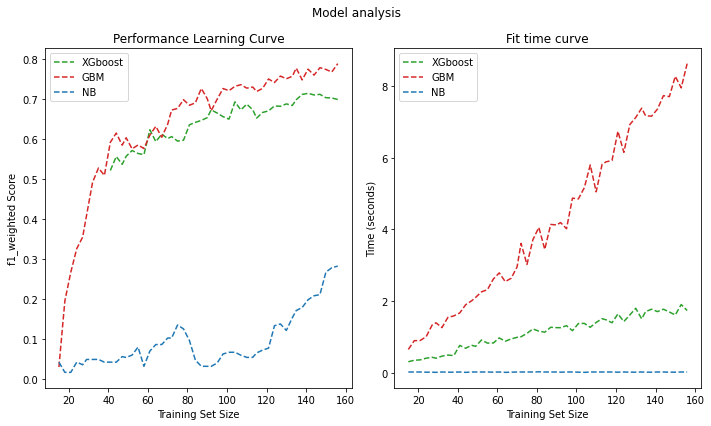

In [79]:
performance_learning_curve([final_XG,final_GBM,MultinomialNB()],X_train_new,y_train_encoded,cv_k=3,train_size=np.linspace(0.1, 1, 50),
                          estimater_names=["XGboost","GBM","NB"])

In [80]:
print("---------Optimised parameters---------")
print("\nXG Model:\n------------------")
for i in best_hyperparams_XG.keys():
    print(f"{i}: {best_hyperparams_XG[i]}")

print("\nGBM Model:\n------------------")
for i in best_hyperparams_GBM.keys():
    print(f"{i}: {best_hyperparams_GBM[i]}")

---------Optimised parameters---------

XG Model:
------------------
alpha: 1
colsample_bytree: 0.3183476227900784
eta: 0.4172454752422733
gamma: 0.4877504053781552
lambda: 0.3315051070173233
max_delta_step: 3
max_depth: 11
min_child_weight: 1

GBM Model:
------------------
learning_rate: 0.1555162204307514
max_depth: 12
max_features: 0.543465781599653
min_samples_leaf: 7
subsample: 0.848900372135685


### Analysis of model results



#### XGboost model 

**Optimised parameters**


Through the process of parameter optimsation it was clear that the XGboost algorithim on our data was highly-paramater dependant, there was a huge range in weighted f-scores, with the worst tests showing a score of less than 0.1, and the best showing a score above 0.7. It would appear that the time spent on parameter optimization was worth it, clearly the model generalizes well, as can be seen by the relativily smooth increase in accuracy as training size increases. Note that on each itteration a different portion of training data is selected for validation and training, thus; we would expect a good model performance learning curve to be both smooth, and to increase as training size increases. Ontop of this, reasonable accuracy was seen even on small training data sets, with a weighted f1-score of 0.5 with 35 records used for training. XGboost did however fail to make predictions on training datasets smaller than this. Interestingly, the fit time for XGboost is relativly low, and infact the rate of increase of fit time relative to training dataset size is also increases quite low.  it is possible therefore, that if this model was to be generalized to a huge corpus, fitting time could become an issue. Luckily, this implemntation of XGBoost is distributed, meaning aslong as there is sufficent computing power (or access to a distributed-computing cluster), the model can be scaled to much larger datasets.

As training size increases, the rate of change of accuracy decreases. This could suggest there is a plateu in the model's performance, To reach significantly higher accuracy than is seen here could require the use of more complex features, for example; rather than using tf-idf features it may be worth utalising word2vec, or gloVe for word embedding, which would help capture the context of words better and could be more representative of the authors style of writing. 


#### GBM model 

As could be expected, sklearn's GBM implementation saw very similar accuracy to the XGboost model, a notable difference, however is fit time. Hyperopt found that the best max_depth for the GBM was much higher than that of XGboost, which slowed the algorithim down quite alot. 


#### Naieve Bayes model

This model was more evaluated just for the purpose of showing how much better the ensamble methods were, clearly it performed quite poorly, the one redeeming factor however is; it is extremly fast to fit compared to the other two. 

#### Final model.

To finish, we will train and fit the a final model, using the best parameters found in the above tests. 

              precision    recall  f1-score   support

           0       0.71      0.56      0.63         9
           1       0.88      0.78      0.82         9
           2       0.88      0.96      0.92        24
           3       0.62      0.84      0.71        19
           4       1.00      1.00      1.00         9
           5       0.67      0.67      0.67         9
           6       1.00      0.87      0.93        15
           7       0.58      0.58      0.58        12
           8       0.57      0.36      0.44        11

    accuracy                           0.77       117
   macro avg       0.77      0.73      0.74       117
weighted avg       0.77      0.77      0.76       117



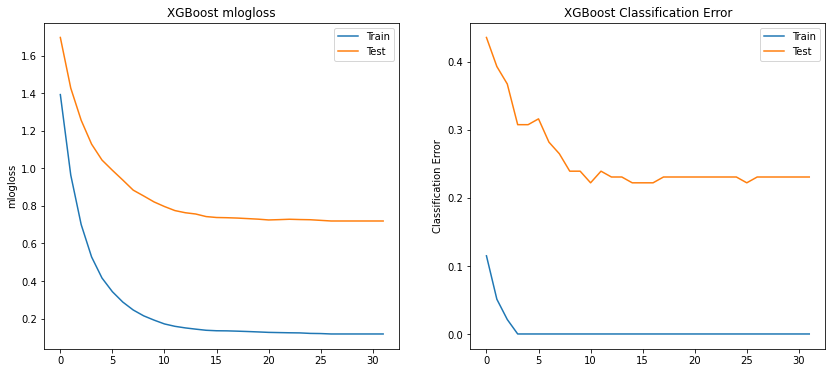

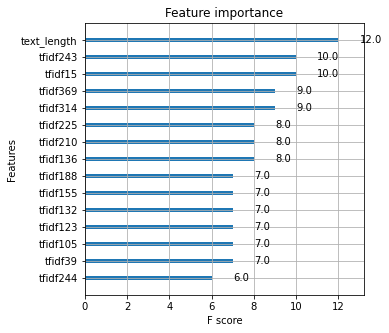

In [81]:
## final model 
# creating an evaluation set to generate validation curves.
eval_set = [(X_train_new, y_train_encoded), (X_test_new, y_test_encoded)]
final_XG.set_params(early_stopping_rounds=5,eval_metric=["merror", "mlogloss"])
final_model =final_XG.fit(X_train_new,y_train_encoded,eval_set=eval_set,verbose=False)

final_results = final_model.predict(X_test_new)

print(classification_report(y_test_encoded,final_results))

final_results_metrics = final_XG.evals_result()


train_mlogloss = final_results_metrics["validation_0"]["mlogloss"]
test_mlogloss = final_results_metrics["validation_1"]["mlogloss"]

train_merror = final_results_metrics["validation_0"]["merror"]
test_merror = final_results_metrics["validation_1"]["merror"]
epochs = len(train_mlogloss)

x_axis = range(0, epochs)

fig, (ax1,ax2,) = plt.subplots(1,2,figsize=(14,6))
ax1.plot(x_axis, train_mlogloss, label='Train')
ax1.plot(x_axis, test_mlogloss, label='Test')
ax1.legend()
ax1.set_ylabel('mlogloss')
ax1.set_title('XGBoost mlogloss')


ax2.plot(x_axis, train_merror, label='Train')
ax2.plot(x_axis, test_merror, label='Test')
ax2.legend()
plt.ylabel('Classification Error')
ax2.set_title('XGBoost Classification Error')

plt.show()

fig, ax = plt.subplots(1,1,figsize=(5,5))
xgb.plot_importance(final_model, max_num_features=15, ax=ax)
plt.show()

### Conclusion 

In this project we set out with the goal of generating a predictive model that could correctly classify, and thus identify an author solely on bodies of text that they produce. Using article data scraped from the BBC website We made good progress achieving this goal, by producing a model that could correctly classify articles with an overall accuracy of 76%. In general, authors that had written fewer articles saw worst scores in the final model, with the lowest having an f1-score of only 0.44.

We identified that out of three explored models, namely, multinominal naieve bayes, sklearn's implementation of a GBM classifier, and XGboost, XGboost performed the best overall.Although its accuracy was basically the exact same as sklearn's GBM, the speed to fit is significantly faster.The main reason for this is, it has a lower maximum depth (5 vs 12) The model also generalises well to unseen data, This can be seen in both the performance learning curve, and the above logloss curve which shows a continously steady decline in mlogloss on par with the training data set. Meaning this is a good basis for future work on a larger corpus. The terms created from tf-idf were by far the most important features, with 13 of the 15 most important features in the final model being tfidf variables which builds on the theory that having access to a larger corpus would greatly benefit the results seen by the model.




## References

A. Voutilainen, 2003. Part-of-speech tagging (Vol. 219). The Oxford handbook of computational linguistics.



T. Mikolov, K. Chan, G. Corrado, J. Dean, 2013, ‘Efficient estimation of word representations in vector space’, arXiv preprint



A. Onan and M. A. Toçoğlu, 2021, ‘A Term Weighted Neural Language Model and Stacked Bidirectional LSTM Based Framework for Sarcasm Identification’, IEEE, vol. 9, pp. 7701-7722


Y. Zhang, R. Jin, Z. H. Zhou, 2010. Understanding bag-of-words model: a statistical framework. International journal of machine learning and cybernetics, 1(1), pp.43-52.

R. Rehurek, and P. Sojka, 2011. Gensim–python framework for vector space modelling. NLP Centre, Faculty of Informatics, Masaryk University, Brno, Czech Republic, 3(2).